# Credit Risk Assessment
## Final Project-Based Virtual Intern: Data Scientist ID/X Partners x Rakamin Academy

by Galih Rakasiwi

# Import Libraries & Load Dataset

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib as mpl
from sklearn.preprocessing import PowerTransformer
from scipy.stats import zscore, boxcox
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [ ]:
# Load Dataset
df = pd.read_csv('loan_data_2007_2014.csv')

# Data Understanding

In [ ]:
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

In [ ]:
print("\nJumlah Baris dan Kolom:", df.shape)

In [ ]:
df.describe()

In [ ]:
df.duplicated().sum()

## Handling Missing Values

In [ ]:
# mengecek missing values keseluruhan
df.isnull().sum().sum()

In [ ]:
# Menghitung persen missing values
missing_values = df.isnull().sum() / len(df) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Menampilkan kolom dengan missing values
print("\nPersentase Missing Values dalam Dataset:\n")
print(missing_values)

In [ ]:
# Menghapus kolom dengan missing values > 50%
threshold = 50
cols_to_drop = missing_values[missing_values > threshold].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)

print(f"\nKolom dihapus karena missing lebih dari {threshold}%:\n", cols_to_drop)

In [ ]:
# Menangani missing values pada kolom yang tersisa
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

# Verifikasi hasil
print("\nMissing values setelah penanganan:\n")
print(df.isnull().sum())

## Cleaning Data

In [ ]:
columns_to_drop = [
    'Unnamed: 0','id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'out_prncp', 'out_prncp_inv',
    'annual_inc_joint', 'dti_joint', 'verification_status_joint'
]

df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

In [ ]:
df.info()

In [ ]:
df.shape

# Exploratory Data Analysis (EDA)

## Visualisasi Univariat

In [ ]:
# Distribusi Fitur Kategorikal
categorical_features = ["term", "grade", "home_ownership", "verification_status", "loan_status", "purpose"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"Distribusi {col}")
    plt.xlabel("Jumlah")
plt.tight_layout()
plt.show()

In [ ]:
# Distribusi Variabel Numerik
numerical_features = ["loan_amnt", "funded_amnt", "int_rate", "annual_inc", "dti", "total_pymnt", "total_rec_int"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribusi {col}")
plt.tight_layout()
plt.show()


In [ ]:
# Distribusi Target Variabel: Loan Status
plt.figure(figsize=(15, 8))
sns.countplot(data=df, y='loan_status')
plt.xlabel('count')
plt.ylabel('loan_status')
plt.title("Target variable distribution")
plt.show()

# Visualisasi Bivariet

In [ ]:
# Korelasi Antar Fitur Menggunakan Heatmap
num = df.select_dtypes(include=['number'])

corr_matrix = num.corr()

plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

In [ ]:
# Hubungan antara Loan Amount dan Annual Income
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["loan_amnt"], y=df["annual_inc"], alpha=0.5)
plt.title("Hubungan antara Loan Amount dan Annual Income", fontsize=14)
plt.xlabel("Loan Amount")
plt.ylabel("Annual Income")
plt.show()

In [ ]:
# Distribusi Fitur Numerik Berdasarkan Loan Status
target = 'loan_status'
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features[:9], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[target], y=df[col])
    plt.title(f"Box Plot of {col} by {target}")
plt.tight_layout()
plt.show()

# Data Preparation

## Feature Enginnering

In [ ]:
# 1. Konversi term menjadi numerik (dari "36 months" atau "60 months" menjadi 3 dan 5 tahun)
df['term'] = df['term'].str.extract('(\d+)').astype(int) / 12

# 2. Rasio Pendapatan terhadap Pinjaman (Income to Loan Ratio)
df['income_to_loan_ratio'] = df['annual_inc'] / df['loan_amnt']

# 3. Rasio Angsuran terhadap Pendapatan (Installment to Income Ratio)
df['installment_to_income_ratio'] = df['installment'] / (df['annual_inc'] / 12)

# 4. Binarisasi lama masa kerja (emp_length), 1 jika lebih dari 2 tahun, 0 jika kurang
df['emp_length'] = df['emp_length'].replace({'< 1 year': '0', '10+ years': '10'}).str.extract('(\d+)').astype(float)
df['emp_length'] = (df['emp_length'] > 2).astype(int)

# 5. Konversi Grade menjadi numerik (A-G menjadi 1-7)
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade'] = df['grade'].map(grade_mapping)

In [ ]:
print("\nDataset setelah Feature Engineering:\n")
df.head()

## Handling Skewness & Outliers

In [ ]:
# Hanya kolom numerik
numerical_features = df.select_dtypes(include=['number']).columns

In [ ]:
# Deteksi Outliers dengan IQR
def detect_outliers_iqr(df):
    outliers = {}
    for col in numerical_features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    return outliers

outliers_iqr = detect_outliers_iqr(df)
print("\nJumlah Outliers per Kolom (IQR Method):\n", outliers_iqr)

In [ ]:
# Deteksi Outliers dengan Z-Score
def detect_outliers_zscore(df, threshold=3):
    z_scores = df[numerical_features].apply(zscore)
    outliers = (z_scores.abs() > threshold).sum()
    return outliers

outliers_zscore = detect_outliers_zscore(df)
print("\nJumlah Outliers per Kolom (Z-Score Method):\n", outliers_zscore)

In [ ]:
# Visualisasi Outliers dengan Boxplot
plt.figure(figsize=(15, 8))
df[numerical_features].boxplot(rot=90)
plt.title("Boxplot untuk Deteksi Outliers")
plt.show()

In [ ]:
# Fungsi untuk menangani skewness
def handle_skewness(df, threshold=0.5, use_yeo_johnson=False):
    numerical_df = df.select_dtypes(include=['number'])
    skewness = numerical_df.skew()
    skewed_features = skewness[abs(skewness) > threshold].index

    print("Skewness Before Transformation:")
    print(skewness[skewed_features])

    for col in skewed_features:
        if use_yeo_johnson:
            # Menggunakan Yeo-Johnson Transformation
            pt = PowerTransformer(method='yeo-johnson')
            df[[col]] = pt.fit_transform(df[[col]])
        else:
            if df[col].min() > 0:
                if skewness[col] > 1:
                    df[col] = np.log1p(df[col])  # Log Transform
                else:
                    df[col] = np.cbrt(df[col])  # Cube Root
            else:
                df[col] = np.cbrt(df[col])  # Cube Root untuk nilai negatif

    # Hitung skewness setelah transformasi
    new_skewness = df[numerical_df.columns].skew()
    print("\nSkewness After Transformation:")
    print(new_skewness[skewed_features])

    return df

## Transformasi Data dan Encoding untuk Prediksi Status Pinjaman

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

def map_to_good_bad_loan(y):
    good_loans = ['Fully Paid', 'Current']
    bad_loans = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off',
                 'Does not meet the credit policy. Status:Fully Paid', 'In Grace Period',
                 'Late (16-30 days)', 'Late (31-120 days)']
    return y.apply(lambda x: 'Good Loan' if x in good_loans else 'Bad Loan')

y = map_to_good_bad_loan(y)

label_encoder = LabelEncoder()

for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_encoder.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling

## Model Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

## Model Random Forest

In [ ]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)  # Default 100 estimators for better performance
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Hyperparameter Tuning

# Evaluasi Model

In [ ]:
def evaluate_model_visual(y_test, y_pred, model_name, model_proba=None):
    print("=" * 50)
    print(f"Evaluating Model: {model_name}")
    print("=" * 50)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    try:
        if len(set(y_test)) > 2 and model_proba is not None:
            roc_auc = roc_auc_score(y_test, model_proba, multi_class="ovr", average="weighted")
        else:
            roc_auc = roc_auc_score(y_test, model_proba[:, 1])
    except ValueError:
        roc_auc = "Not Applicable (Single Class Detected)"
    except Exception as e:
        print(f"Error calculating ROC AUC: {e}")
        roc_auc = "Error in ROC AUC calculation"

    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print(f"ROC AUC Score  : {roc_auc}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

## Evaluasi Model Logistic Regression

Evaluating Model: Logistic Regression
Accuracy       : 0.9322
Precision      : 0.9337
Recall         : 0.9322
F1 Score       : 0.9218
ROC AUC Score  : 0.9024796853889518

Classification Report:
              precision    recall  f1-score   support

    Bad Loan       0.95      0.47      0.63     11457
   Good Loan       0.93      1.00      0.96     81800

    accuracy                           0.93     93257
   macro avg       0.94      0.73      0.80     93257
weighted avg       0.93      0.93      0.92     93257



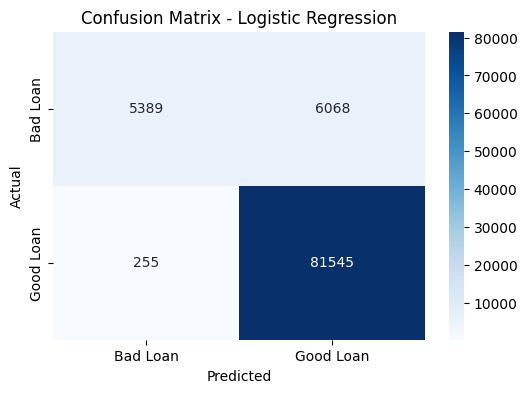

In [57]:
evaluate_model_visual(y_test, y_pred_lr, "Logistic Regression", model_proba=log_reg.predict_proba(X_test))

## Evaluasi Model Random Forest

Evaluating Model: Random Forest
Accuracy       : 0.9833
Precision      : 0.9835
Recall         : 0.9833
F1 Score       : 0.9828
ROC AUC Score  : 0.9860925128144719

Classification Report:
              precision    recall  f1-score   support

    Bad Loan       1.00      0.87      0.93     11457
   Good Loan       0.98      1.00      0.99     81800

    accuracy                           0.98     93257
   macro avg       0.99      0.93      0.96     93257
weighted avg       0.98      0.98      0.98     93257



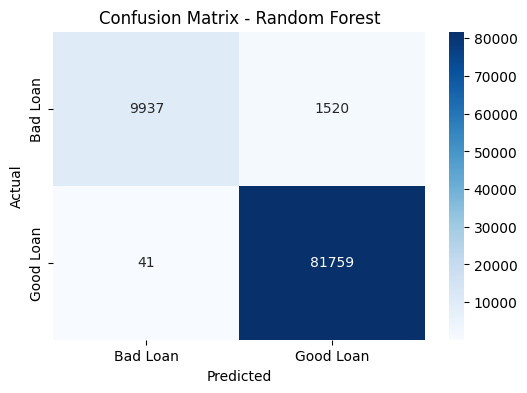

In [58]:
evaluate_model_visual(y_test, y_pred_rf, "Random Forest", model_proba=rf_clf.predict_proba(X_test))

## Perbandingan Algoritma yang digunakan

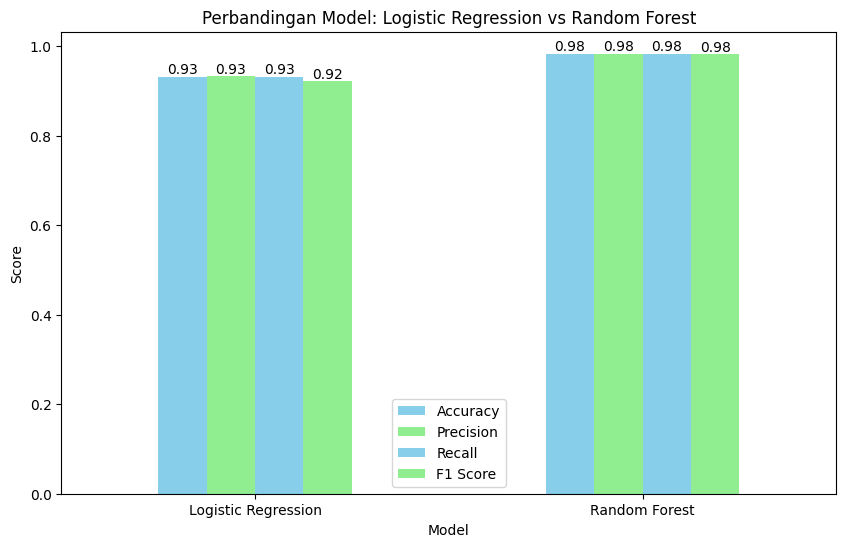

In [59]:
def get_model_metrics(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

log_reg_metrics = get_model_metrics(y_test, y_pred_lr, 'Logistic Regression')
rf_metrics = get_model_metrics(y_test, y_pred_rf, 'Random Forest')

metrics_df = pd.DataFrame([log_reg_metrics, rf_metrics])

ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen'])

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Perbandingan Model: Logistic Regression vs Random Forest')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Kesimpulan

Model Random Forest menunjukkan kinerja yang lebih baik dibandingkan dengan Logistic Regression. Dengan akurasi 98.33%, Precision 98.35%, dan Recall 98.33%, model ini mampu memprediksi dengan sangat baik, terutama dalam mengidentifikasi kategori "Good Loan". Sementara itu, Logistic Regression memiliki akurasi 93.22% dengan Precision 93.37% dan Recall 93.22%, namun performanya lebih rendah terutama dalam mengidentifikasi kategori "Bad Loan". Secara keseluruhan, Random Forest memberikan hasil yang lebih optimal dalam hal akurasi, precision, dan recall.